In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet 

from sklearn import tree
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Leitura de Arquivos

In [2]:
##Dados do Banco Mundial
#Gerais
path_wb = 'World_Bank' #Informando pasta onde os arquivos .csv estão 
csv_files_wb = glob.glob(path_wb + "/*.csv") #Listando todos os nomes dos arquivos .csv 
list_wb = (pd.read_csv(file, sep=',', skiprows=4) for file in csv_files_wb) #Transformando em um gerador de lista de Dataframes

df_wb = list(list_wb) #Criando a lista de Dataframe final

##Dados Externos

path_ext = 'Extern Data' 
csv_files_ext = glob.glob(path_ext + "/*.csv")
list_ext = (pd.read_csv(file, sep=',') for file in csv_files_ext)

df_ext = list(list_ext)

#Dados Externos 2 - Segundo Dataset de Liberdade Econômica do "Fraser Institute"

path_fra = 'EFW_1970_2022.csv'
df_efw_fra = pd.read_csv(path_fra, sep=';')

# Primeira vizualização e tratamento dos datasets.

In [3]:
#data_bill.country.unique()
#len(set(df_ext[3].Country).difference(set(df_hdi[0]['Country Name'])))

#set(df_ext[2].countries).difference(set(df_efw_fra.Countries))
#len(set(df_hdi[0]['Country Name']).intersection(set(df_ext[2].countries)))
#set(df_efw_fra.Countries).difference(set(df_wb[1]['Country Name']))

#len(set(df_ext[2].countries)), len(set(df_hdi[0]['Country Name']))

## Padronizando Nomes dos Países de Estudo

In [4]:
#Dataset de Bilionarios.
data_bill = df_ext[0]
data_bill.drop('Unnamed: 0', axis=1, inplace=True)
data_bill.set_index('rank')
data_bill['networth']=data_bill['networth'].str.replace('$','', regex=True)
data_bill['networth']=data_bill['networth'].str.replace(' B','', regex=True)
data_bill['networth']=data_bill['networth'].apply(pd.to_numeric)

data_bill.replace({'country': {'Eswatini (Swaziland)': 'Eswatini'}}, inplace=True)

df_ext[0] = data_bill 

####

#Dataset de Liberdade Economica.
data_efw = df_ext[2]
data_efw.replace({'countries': {'Bahamas': 'Bahamas, The',
                                'Cape Verde': 'Cabo Verde',
                                'Central Afr. Rep.': 'Central African Republic',
                                'Congo, Dem. R.': 'Congo, Dem. Rep.',
                                'Congo, Rep. Of':  'Congo, Rep.',
                                'Czech Rep.': 'Czech Republic',
                                'Dominican Rep.': 'Dominican Republic',
                                'Egypt': 'Egypt, Arab Rep.',
                                'Hong Kong': 'Hong Kong SAR, China',
                                'Iran': 'Iran, Islamic Rep.',
                                'Korea, South': 'Korea, Rep.',
                                'Laos': 'Lao PDR',
                                'Macedonia': 'North Macedonia',
                                'Pap. New Guinea': 'Papua New Guinea',
                                'Russia': 'Russian Federation',
                                'Slovak Rep': 'Slovak Republic',
                                'Swaziland': 'Eswatini',
                                'Syria': 'Syrian Arab Republic',
                                #'Taiwan',
                                'Trinidad & Tob.': 'Trinidad and Tobago',
                                'Turkey': 'Turkiye',
                                'Unit. Arab Em.': 'United Arab Emirates',
                                'Venezuela': 'Venezuela, RB'}}, inplace=True)
                                    
df_ext[2] = data_efw

####

#Dataset de Indice de Desenvolvimento Humano.
data_HDI = df_ext[3]
data_HDI['Country'] = data_HDI['Country'].astype(str)
data_HDI['Country'] = data_HDI['Country'].str.strip()
data_HDI.replace({'Country': {'Bahamas': 'Bahamas, The',
                              'Bolivia (Plurinational State of)': 'Bolivia',
                              'Congo': 'Congo, Rep.',
                              'Congo (Democratic Republic of the)': 'Congo, Dem. Rep.',
                              'Czechia': 'Czech Republic',
                              "Côte d'Ivoire": "Cote d'Ivoire",
                              'Egypt': 'Egypt, Arab Rep.',
                              'Eswatini (Kingdom of)': 'Eswatini',
                              'Gambia': 'Gambia, The',
                              'Hong Kong, China (SAR)': 'Hong Kong SAR, China',
                              'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
                              'Korea (Republic of)': 'Korea, Rep.',
                              'Kyrgyzstan': 'Kyrgyz Republic',
                              "Lao People's Democratic Republic": 'Lao PDR',
                              'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.',
                              'Moldova (Republic of)': 'Moldova',
                              'Palestine, State of': 'West Bank and Gaza',
                              'Saint Kitts and Nevis': 'St. Kitts and Nevis',
                              'Saint Lucia': 'St. Lucia',
                              'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
                              'Slovakia': 'Slovak Republic',
                              'Tanzania (United Republic of)': 'Tanzania',
                              'The former Yugoslav Republic of Macedonia': 'North Macedonia',
                              'Turkey': 'Turkiye',
                              'Venezuela (Bolivarian Republic of)': 'Venezuela, RB',
                              'Viet Nam': 'Vietnam',
                              'Yemen': 'Yemen, Rep.'}}, inplace=True)

df_ext[3] = data_HDI 
####

#Dataset de Unicornios.
data_uni = df_ext[4]
data_uni['Valuation(US$ billions)'] = data_uni['Valuation(US$ billions)'].str.replace('+','')
data_uni['Valuation(US$ billions)'] = data_uni['Valuation(US$ billions)'].astype(float)
data_uni['Country/countries'] = data_uni['Country/countries'].astype(str)
data_uni['Country/countries'] = data_uni['Country/countries'].apply(lambda x: str(x).replace(u'\xa0', u''))
data_uni.replace({'Country/countries': {'US': 'United States',
                             'US / Ireland': 'United States',
                             'UK': 'United Kingdom',
                             'UK / UAE': 'United Kingdom',
                             'Ukraine[39]/United States[40]': 'Ukraine',
                             'China / Hong Kong': 'China',
                             'Hong Kong / China': 'Hong Kong SAR, China',
                             'Portugal / US': 'Portugal',
                             'US[67]': 'United States',
                             'India / US': 'India',
                             'Australia / Hong Kong': 'Australia',
                             'China / US': 'China',
                             'UK / US': 'United Kingdom',
                             'France / US': 'France',
                             'Israel / US': 'Israel',
                             'Brazil / US': 'Brazil',
                             'US / Israel': 'United States',
                             'Argentina / US': 'Argentina',
                             'Portugal / US [308]': 'Portugal',
                             'Senegal / US': 'Senegal',
                             'Israel /  US': 'Israel',
                             'Nigeria / US': 'Nigeria',
                             'US[362]': 'United States',
                             'USA': 'United States',
                             'Spain / US': 'Spain',
                             'Germany / Russia': 'Germany',
                             'Singapore / Israel': 'Singapore',
                             'US, UK and Europe': 'United States',
                             'Singapore / Switzerland': 'Singapore',
                             'UAE': 'United Arab Emirates',
                             'Canada / USA': 'Canada',
                             'India/ US': 'India',
                             'Croatia / UK': 'Croatia',
                             'India / Singapore': 'India',
                             'Armenia / US': 'Armenia',
                             'Estonia / US': 'Estonia'}}, inplace=True)
data_uni.columns = ['Company', 'Valuation(US$ billions)', 'Valuation date', 'Industry',
       'country', 'Founder(s)']

df_ext[4] = data_uni 

####

#Dataset de EFW - Fraser Institute.

df_efw_fra = df_efw_fra[df_efw_fra['Countries'].notna()]
df_efw_fra = df_efw_fra.loc[:, 'Year' : '5  Regulation']
df_efw_fra = df_efw_fra.drop(columns=['ISO Code 2', 'ISO Code 3','data', 'data.1', 'data.2', 'data.3',
                                      'data.4', 'data.5', 'data.6', 'data.7', 'data.8', 'data.9', 'data.10'])

df_efw_fra.replace({'Countries': {#'Somalia',
                                  #'Taiwan',
                                  'Turkey': 'Turkiye'}}, inplace=True)
cols = df_efw_fra.columns[df_efw_fra.dtypes.eq('object')]

df_efw_fra['Economic Freedom Summary Index'] = df_efw_fra['Economic Freedom Summary Index'].str.replace(',','.')
df_efw_fra.iloc[:,5:] = df_efw_fra.iloc[:,5:].apply(lambda x: x.str.replace(',','.'))
df_efw_fra[cols[1:]] = df_efw_fra[cols[1:]].apply(pd.to_numeric, errors='coerce', axis=1)
df_efw_fra['Year'] = df_efw_fra['Year'].astype(int)
df_efw_fra = df_efw_fra.sort_values(by=['Countries', 'Year'])
df_efw_fra = df_efw_fra.reset_index(drop=True)
df_efw_fra = df_efw_fra.interpolate(method='linear', limit_direction='both', axis=0)

In [5]:
#df_efw_fra[df_efw_fra['Countries'] == 'Brazil'].shape

In [6]:
#df_efw_fra[df_efw_fra['Countries'] == 'Brazil'].isna().sum()

## Criação dos Dataframes de Estudo.

### World Bank 

In [7]:
DF_WB = []

countries = list(df_wb[0]['Country Name'])
size = list(range(len(df_wb)))

for x in range(len(countries)): 
    pais = countries[x]
    
    wb_years = df_wb[0].columns[4:66]
    world_bank = pd.DataFrame({'year':wb_years})
    world_bank['year'] = world_bank.year.astype(int)
    world_bank['Country'] = pais
    
    for y in size:
    
        wb = df_wb[y][df_wb[y]['Country Name'] == pais].loc[:,'1960':'2021'].transpose()
        wb = wb.reset_index()
        pin = df_wb[y]['Indicator Name'][0]
        wb.columns = ['year', pin]
        #print(wb.columns)
        wb['year'] = wb.year.astype(int)
        world_bank = pd.merge(world_bank, wb, how = 'outer', on = 'year')
    
    DF_WB.append(world_bank)


DF_WB_std = pd.DataFrame()

for x in range(len(countries)):
    DF_WB_std = pd.concat([DF_WB_std, DF_WB[x]])
    
DF_WB_std = DF_WB_std.sort_values(by=['Country', 'year'])
DF_WB_std = DF_WB_std.reset_index(drop=True)

### Dados Externos 1

In [8]:
#Escolha dos Países para o Dataframe
countries = np.array(list(set(df_ext[2].countries).intersection(set(df_ext[3].Country))))

#Criação dos DF 
DF_one = pd.DataFrame()
DF_two = pd.DataFrame()

DF_std_ext1 = pd.DataFrame()
list_DF_std_ext2 = []

for x in range(len(countries)): 
    pais = countries[x]
    
    # Parcela A - Liberdade Economica
    a = df_ext[2][df_ext[2]['countries'] == pais].sort_values(by='year')
    a = a.reset_index()
    a = a.drop(columns=['index','ISO_code']) #, inplace=True)

    # Parcela B e C - Bilionarios
    b = df_ext[0][df_ext[0]['country'] == pais].groupby(['country']).name.count()
    c = df_ext[0][df_ext[0]['country'] == pais].groupby(['country']).networth.sum()
    
    # Parcela D - IDH
    d = df_ext[3][df_ext[3]['Country'] == pais].iloc[:,2:].transpose()
    d = d.reset_index()
    if len(set(d.columns)) > 1:
        d.columns = ['year', 'HDI']
    else:
        d.columns = ['year']
    d['year'] = d.year.astype(int)
    d
   
    # Parcela E - Melhores Paises para Startups

    e = df_ext[1][df_ext[1]['country'] == pais].iloc[:,[0,3]].transpose()
    if len(e.columns) > 0:
        e.columns = ['Startups_Score_2020']
    else:
        e
    
    # Parcela M e N - Unicórnios
    
    f = df_ext[4][df_ext[4]['country'] == pais].groupby(['country']).Company.count()
    g = df_ext[4][df_ext[4]['country'] == pais].groupby(['country'])['Valuation(US$ billions)'].sum()
   
    ####
    ####  Unindo os Dataframes
    ####
    
    DF_one = pd.merge(b, c, how = 'outer', on = 'country')
    DF_one = pd.merge(DF_one, f, how = 'outer', on = 'country')
    DF_one = pd.merge(DF_one, g, how = 'outer', on = 'country')
    DF_one = DF_one.reset_index()
    
    if e.shape[1] > 0:
        DF_one['Startups_Ranking_2020'] = e.iloc[0,0]
        DF_one['Startups_Score_2020'] = e.iloc[1,0]
    else:
        e
    
    DF_std_ext1 = pd.concat([DF_std_ext1, DF_one])
    
    ### Unindo os Dataframes em um Único.

    DF_two = pd.merge(a, d, how = 'outer', on = 'year')
    DF_two = DF_two.sort_values(by='year').reset_index(drop=True)
   
    # Preenchendo NaN dos paíes
    df_inter = DF_two.interpolate(method='linear', limit_direction='both', axis=0)
    values = {"countries": pais}
    df_inter = df_inter.fillna(value=values)
    
    list_DF_std_ext2.append(df_inter)

#### Parte 1

In [9]:
DF_std_ext2 = pd.DataFrame()
for x in range(len(countries)):
    DF_std_ext2 = pd.concat([DF_std_ext2, list_DF_std_ext2[x]])
    
DF_std_ext2 = DF_std_ext2.sort_values(by=['countries', 'year'])
DF_std_ext2 = DF_std_ext2.reset_index(drop=True)

DF_std_ext2.columns = ['Year', 'Countries', 'Economic_Freedom', 'Free_rank', 'Quartile',
                  '1.a_government_consumption', '1.b_transfers', '1.c_gov_enterprises',
                  '1.d_top_marg_tax_rate', '1.0_size_government', '2.a_judicial_independence',
                  '2.b_impartial_courts', '2.c_protection_property_rights',
                  '2.d_military_interference', '2.e_integrity_legal_system',
                  '2.f_legal_enforcement_contracts', '2.g_restrictions_sale_real_property',
                  '2.h_reliability_police', '2.i_business_costs_crime',
                  '2.j_gender_adjustment', '2.0_property_rights', '3.a_money_growth',
                  '3.b_std_inflation', '3.c_inflation', '3.d_freedom_own_foreign_currency',
                  '3.0_sound_money', '4.a_tariffs', '4.b_regulatory_trade_barriers',
                  '4.c_black_market', '4.d_control_movement_capital_ppl', '4.0_trade',
                  '5.a_credit_market_reg', '5.b_labor_market_reg', '5.c_business_reg',
                  '5.0_regulation', 'HDI_year']


DF_std_ext1.columns = ['Country', 'No_billionaires', 'Networth_bill', 'No_unicorns',
                       'Valuation_startups_US$_billions', 'Startups_Ranking_2020', 'Startups_Score_2020']
DF_std_ext1 = DF_std_ext1.sort_values(by='Country')
DF_std_ext1 = DF_std_ext1.reset_index(drop=True)

#### Parte 2

In [10]:
# Unindo os 2 DF no DF_std_EXT criando novas colunas com os índices do DF_std_ext2
DF_std_EXT = pd.DataFrame()
DF_std_EXT['Country'] = pd.DataFrame(set(DF_std_ext2.Countries))
lista = list(DF_std_ext2.columns[2:])
for r in lista:
    item = r
    name = r[:4]
    #DF_std_EXT['EFW1_' + name +'_'+'80_20'] = list(DF_std_ext2[DF_std_ext2['Year'] >= 1980].groupby(['Countries'])[r].mean().values)
    #DF_std_EXT['EFW1_' + name +'_'+'00_20'] = list(DF_std_ext2[DF_std_ext2['Year'] >= 2000].groupby(['Countries'])[r].mean().values)
    #DF_std_EXT['EFW1_' + name +'_'+'10_20'] = list(DF_std_ext2[DF_std_ext2['Year'] >= 2010].groupby(['Countries'])[r].mean().values)

    DF_std_EXT['EFW1_' + name +'_'+'80_00'] = list(DF_std_ext2[(DF_std_ext2['Year'] >= 1980) & 
                                                               (DF_std_ext2['Year'] <= 2000)].groupby(['Countries'])[r].mean().values)
    DF_std_EXT['EFW1_' + name +'_'+'00_10'] = list(DF_std_ext2[(DF_std_ext2['Year'] >= 2000) & 
                                                               (DF_std_ext2['Year'] <= 2010)].groupby(['Countries'])[r].mean().values)
    DF_std_EXT['EFW1_' + name +'_'+'10_20'] = list(DF_std_ext2[(DF_std_ext2['Year'] >= 2010) &
                                                               (DF_std_ext2['Year'] <= 2020)].groupby(['Countries'])[r].mean().values)

    
DF_std_EXT = pd.merge( DF_std_ext1, DF_std_EXT, how = 'outer', on = 'Country')
DF_std_EXT.fillna(0, inplace=True)
DF_std_EXT = DF_std_EXT.sort_values(by='Country')
DF_std_EXT = DF_std_EXT.reset_index(drop=True)

### Dados Externos 2 - "Fraser Institute"

In [11]:
lista = list(df_efw_fra.columns[2:])
frazer_institute = pd.DataFrame(list(df_efw_fra.Countries.unique()))
frazer_institute.columns = ['Country']
for r in lista:
    item = r
    name = r[:4]
    #frazer_institute['EFW2_' + name +'_'+'80_20'] = list(df_efw_fra[df_efw_fra['Year'] >= 1980].groupby(['Countries'])[r].mean().values)
    #frazer_institute['EFW2_' + name +'_'+'00_20'] = list(df_efw_fra[df_efw_fra['Year'] >= 2000].groupby(['Countries'])[r].mean().values)
    #frazer_institute['EFW2_' + name +'_'+'10_20'] = list(df_efw_fra[df_efw_fra['Year'] >= 2010].groupby(['Countries'])[r].mean().values)

    frazer_institute['EFW2_' + name +'_'+'80_00'] = list(df_efw_fra[(df_efw_fra['Year'] >= 1980) & 
                                                        (df_efw_fra['Year'] <= 2000)].groupby(['Countries'])[r].mean().values)
    frazer_institute['EFW2_' + name +'_'+'00_10'] = list(df_efw_fra[(df_efw_fra['Year'] >= 2000) & 
                                                        (df_efw_fra['Year'] <= 2010)].groupby(['Countries'])[r].mean().values)
    frazer_institute['EFW2_' + name +'_'+'10_20'] = list(df_efw_fra[(df_efw_fra['Year'] >= 2010) &
                                                        (df_efw_fra['Year'] <= 2020)].groupby(['Countries'])[r].mean().values)

    
DF_std_EXT = pd.merge(DF_std_EXT, frazer_institute, how = 'inner', on = 'Country')

DF_std_EXT.columns = [lista.replace(' ', '') for lista in list(DF_std_EXT.columns)]

## Unindo os Últimos 2 Dataframes Para Criar o Dataframe Final

In [12]:
#Datas >>>> WBC e DF_std_EXT para criar o DF_std (Dataframe final de estudo).

list_of_values = list(DF_std_EXT.Country)
WBB = DF_WB_std[DF_WB_std['Country'].isin(list_of_values)]

perc_corte = 0.30 #Acima desse valor de NaN o Dataset é Excluido do Dataframe 

size = WBB[(WBB['year'] >= 1980)].shape[0] * perc_corte
droplist = list(WBB.columns[list(WBB[(WBB['year'] >= 1980)].isna().sum() >= size)])
WBC = WBB[(WBB['year'] >= 1980)].drop(columns=droplist).reset_index(drop=True).copy()
WBC = WBC.interpolate(method='linear', limit_direction='both', axis=0)

lista = list(WBC.columns[2:])
world_bank = pd.DataFrame(list(WBC.Country.unique()))
world_bank.columns = ['Country']

for r in lista:
    item = r
    name = r[:4]
    #world_bank['WB_' + name +'_'+'80_20'] = list(WBC[WBC['year'] >= 1980].groupby(['Country'])[r].mean().values)
    #world_bank['WB_' + name +'_'+'00_20'] = list(WBC[WBC['year'] >= 2000].groupby(['Country'])[r].mean().values)
    #world_bank['WB_' + name +'_'+'10_20'] = list(WBC[WBC['year'] >= 2010].groupby(['Country'])[r].mean().values)
    
    world_bank['WB_' + name +'_'+'80_00'] = list(WBC[(WBC['year'] >= 1980) & 
                                                    (WBC['year'] <= 2000)].groupby(['Country'])[r].mean().values)
    world_bank['WB_' + name +'_'+'00_10'] = list(WBC[(WBC['year'] >= 2000) & 
                                                    (WBC['year'] <= 2010)].groupby(['Country'])[r].mean().values)
    world_bank['WB_' + name +'_'+'10_20'] = list(WBC[(WBC['year'] >= 2010) &
                                                    (WBC['year'] <= 2020)].groupby(['Country'])[r].mean().values)

DF_std = pd.merge(DF_std_EXT, world_bank, how = 'inner', on = 'Country')
DF_std.columns = [lista.replace(' ', '') for lista in list(DF_std.columns)]

# Exportando Dataframes em formato CSV

In [13]:
DF_std.to_csv(r'EWF_DF.csv', index = False)
DF_std_ext2.to_csv(r'DF_std_ext2.csv', index = False)

# Estudos Primilinares Após Limpeza e União de Dados

<AxesSubplot:xlabel='year', ylabel='GDP (current US$)'>

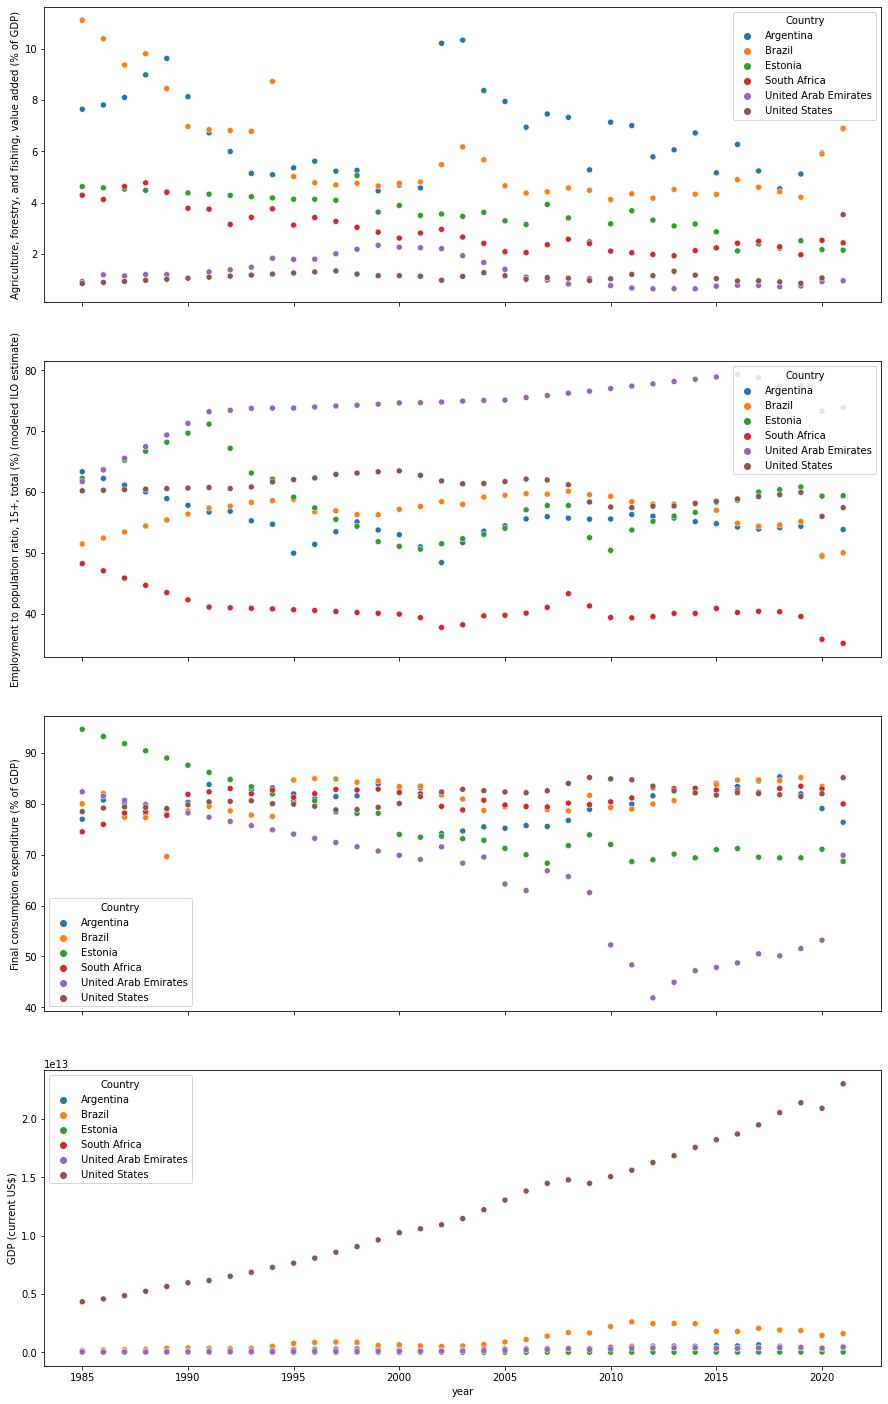

In [14]:
# Dados do World Bank

DF_play = WBC

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15,25))

lista_p= ['Brazil', 'Argentina', 'Estonia', 'United States', 'United Arab Emirates', 'South Africa']

lock = DF_play.Country.isin(lista_p)
data = DF_play[DF_play['year'] >= 1985].loc[lock]

sns.scatterplot(ax=axes[0], data = data, x = data['year'] , y = data[data.columns[2]], hue= data.Country)
sns.scatterplot(ax=axes[1], data = data, x = data['year'] , y = data[data.columns[3]], hue= data.Country)
sns.scatterplot(ax=axes[2], data = data, x = data['year'] , y = data[data.columns[4]], hue= data.Country)
sns.scatterplot(ax=axes[3], data = data, x = data['year'] , y = data[data.columns[6]], hue= data.Country)


<AxesSubplot:xlabel='Year', ylabel='2C  Protection of property rights'>

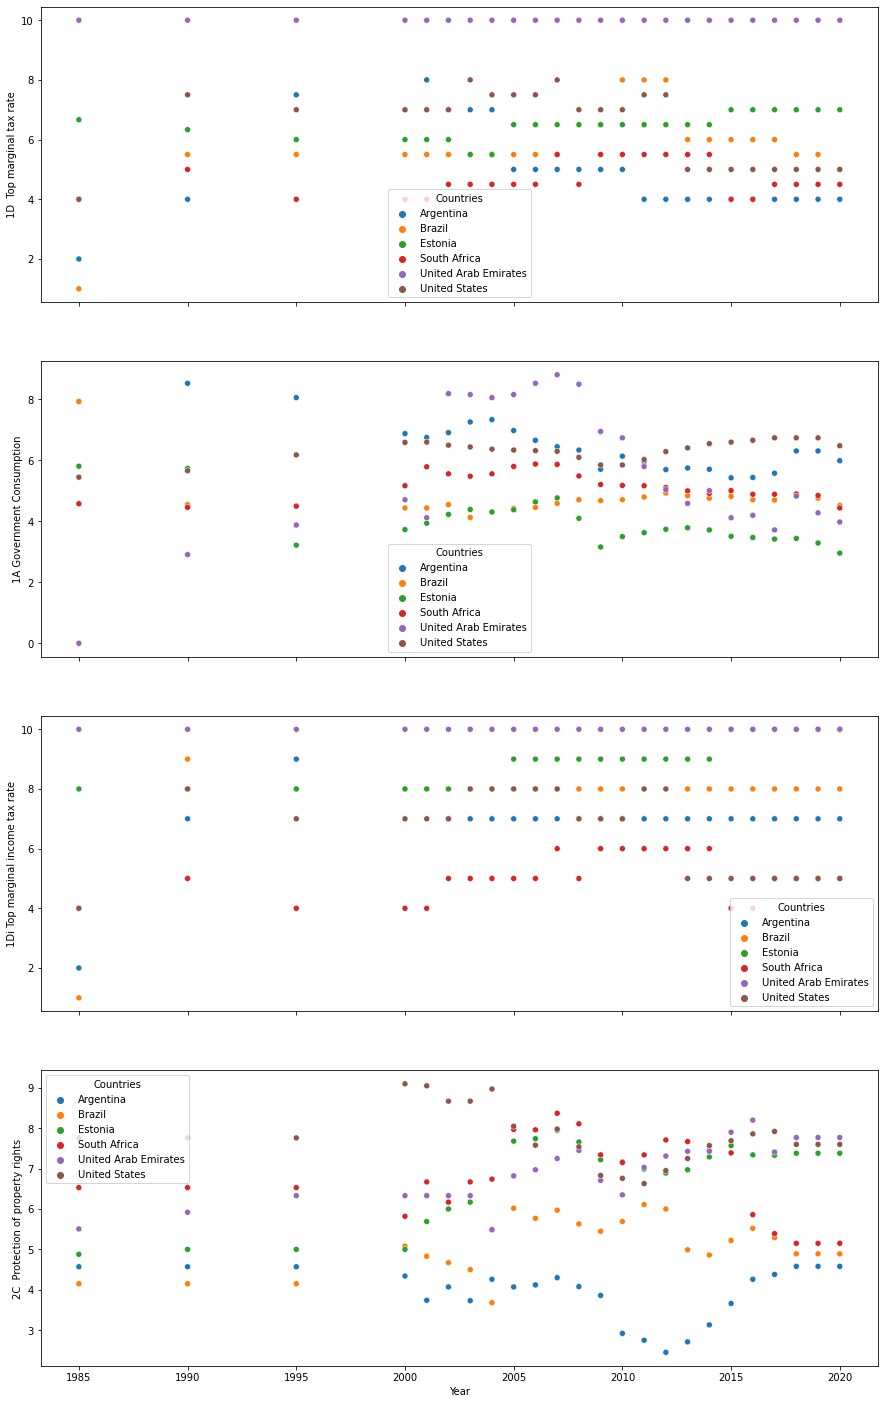

In [15]:
# Dados do World Bank

DF_play = df_efw_fra

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15,25))

lista_p= ['Brazil', 'Argentina', 'Estonia', 'United States', 'United Arab Emirates', 'South Africa']

lock = DF_play.Countries.isin(lista_p)
data = DF_play[DF_play['Year'] >= 1985].loc[lock]

sns.scatterplot(ax=axes[0], data = data, x = data['Year'] , y = data[data.columns[10]], hue= data.Countries)
sns.scatterplot(ax=axes[1], data = data, x = data['Year'] , y = data[data.columns[5]], hue= data.Countries)
sns.scatterplot(ax=axes[2], data = data, x = data['Year'] , y = data[data.columns[8]], hue= data.Countries)
sns.scatterplot(ax=axes[3], data = data, x = data['Year'] , y = data[data.columns[15]], hue= data.Countries)


In [16]:
#pd.crosstab(DF_std2.Country, DF_std2.Emp_2000_2020)

# Aplicando Modelo de ML

In [17]:
### Determinando Dataframe do Modelo

feature_cols_EFW1 = list(DF_std.iloc[:,5:7].columns) + list(DF_std.iloc[:,7:109].columns)
feature_cols_EFW2 = list(DF_std.iloc[:,5:7].columns) + list(DF_std.iloc[:,109:268].columns)
feature_cols_WB = list(DF_std.iloc[:,5:7].columns) + list(DF_std.iloc[:,268:].columns)

feature_cols_base = list(DF_std.iloc[:,1:].columns)

feature_cols = feature_cols_base
feature_cols.remove('Startups_Ranking_2020')
feature_cols.remove('Startups_Score_2020')

X = DF_std[DF_std['Startups_Score_2020'] > 0 ][feature_cols].copy()
y = DF_std[DF_std['Startups_Score_2020'] > 0 ].Startups_Score_2020

#X = DF_std[feature_cols].copy()
#y = DF_std.Startups_Score_2020

#normalizando os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

SEED = 10
TS = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TS, random_state = SEED)

In [18]:
X.shape

(59, 301)

In [19]:
#DF_std[DF_std['Startups_Score_2020']> 0]

In [20]:
DF_std.head()

,Country,No_billionaires,Networth_bill,No_unicorns,Valuation_startups_US$_billions,Startups_Ranking_2020,Startups_Score_2020,EFW1_Econ_80_00,EFW1_Econ_00_10,EFW1_Econ_10_20,...,WB_Popu_10_20,WB_Rura_80_00,WB_Rura_00_10,WB_Rura_10_20,WB_Serv_80_00,WB_Serv_00_10,WB_Serv_10_20,WB_Unem_80_00,WB_Unem_00_10,WB_Unem_10_20
0,Albania,0.0,0.0,0.0,0.00,0.0,0.000,5.482308,6.109091,6.37125,...,2.881045e+06,62.952381,53.220091,42.686545,40.646670,43.934005,46.284482,14.530000,16.107909,14.381727
1,Algeria,1.0,5.1,0.0,0.00,0.0,0.000,6.300000,6.126364,5.76625,...,3.980797e+07,48.055810,36.208091,29.236545,42.645246,34.680905,44.744191,21.323310,17.920000,10.558727
2,Angola,0.0,0.0,0.0,0.00,0.0,0.000,6.920000,6.920000,6.92375,...,2.797158e+07,62.796476,44.574455,36.612545,31.132718,36.465596,43.932164,6.394334,4.403000,7.660182
3,Argentina,6.0,14.0,3.0,7.55,39.0,4.613,7.666154,7.971818,8.00375,...,4.311207e+07,13.454333,9.982364,8.505727,56.883424,53.090517,54.459380,9.663095,12.277273,8.271091
4,Armenia,0.0,0.0,1.0,1.00,65.0,1.078,7.335385,7.460909,7.41000,...,2.920662e+06,33.515000,36.036545,36.795727,49.900141,47.035681,49.042401,6.786143,12.320636,18.226000


## Funções

In [21]:
### Função de Print de Resultados

def resultados(y_pred):
    print('MAE:', mean_absolute_error(y_test, y_pred).round(2))
    print('MSE:', mean_squared_error(y_test, y_pred).round(2))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
    print ('MAPE:', mean_absolute_percentage_error(y_test, y_pred).round(2))
    print('R2:', r2_score(y_test, y_pred).round(2))
    
### Função de Plot de Resultados y_test

def res_model(model):
    y_pred = model.predict(X_test)
    ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=range(len(y_pred)), y=y_pred,
                 label="Valores Previstos",
                 color='red', marker='o',
                 linestyle='--', linewidth=1)

    sns.lineplot(x=range(len(y_pred)),y=y_test,
                 label="Valores Reais",
                 color='blue', marker='X',
                 linestyle=':', linewidth=3)

    plt.legend(loc="best")
    plt.title('Comparação de Valores', fontsize=18)
    plt.xlabel('Country Index', fontsize=14)
    plt.ylabel('Startups_Score_2020', fontsize=14)
    plt.xticks(rotation=0)
    ax


## Linear Regression

In [22]:
"""
filterlist = list(DF_std.columns[list(DF_std.isna().sum() > 0)])

DF_NaN = DF_std.loc[:, DF_std.columns.isin(filterlist)].copy()

#DF_NaN[DF_NaN.EFW2_1Dii_80_20.isna()]

set(DF_std.Country).difference(set(DF_std.iloc[list(DF_NaN.dropna().index)].Country))
"""

'\nfilterlist = list(DF_std.columns[list(DF_std.isna().sum() > 0)])\n\nDF_NaN = DF_std.loc[:, DF_std.columns.isin(filterlist)].copy()\n\n#DF_NaN[DF_NaN.EFW2_1Dii_80_20.isna()]\n\nset(DF_std.Country).difference(set(DF_std.iloc[list(DF_NaN.dropna().index)].Country))\n'

In [23]:
model = LinearRegression(fit_intercept = True)

model.fit(X_train, y_train)

test_sklearn = np.array(X_test)
model.predict(test_sklearn)

y_pred = model.predict(X_test)

cv = ShuffleSplit(n_splits=5, test_size=TS, random_state=SEED)
CV = cross_val_score(model, X, y, cv=cv)

resultados(y_pred)
print('Cross Validation:', CV.round(2))

MAE: 8.35
MSE: 105.49
RMSE: 10.27
MAPE: 7.09
R2: -5.95
Cross Validation: [-5.95 -1.36  0.38 -5.23  0.03]


## Linear Lasso Regression

In [24]:
alpha = 1.83
max_iter = 1

model_l = Lasso(alpha=alpha, max_iter= max_iter)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TS, random_state = SEED)

model_l.fit(X_train, y_train)
ypred_lasso = model_l.predict(X_test)

#print('Coeficientes: ', model_l.coef_)

cv = ShuffleSplit(n_splits=5, test_size=TS, random_state=SEED)
CV = cross_val_score(model_l, X, y, cv=cv)

resultados(ypred_lasso)
print('Cross Validation:', CV.round(2))

MAE: 3.9
MSE: 18.54
RMSE: 4.31
MAPE: 2.96
R2: -0.22
Cross Validation: [-0.22  0.14  0.06 -0.2  -0.2 ]


In [25]:
G = DF_std[feature_cols].copy()
#X_train.columns[model_l.coef_ > 0]
#G.columns,
G.columns[model_l.coef_ > 0]

Index(['No_billionaires', 'Networth_bill', 'No_unicorns', 'EFW2_2L_80_00'], dtype='object')

In [26]:
df_efw_fra.columns

Index(['Year', 'Countries', 'Economic Freedom Summary Index', 'Rank',
       'Quartile', '1A Government Consumption', '1B  Transfers and subsidies',
       '1C  Government investment', '1Di Top marginal income tax rate',
       '1Dii Top marginal income and payroll tax rate',
       '1D  Top marginal tax rate', 'IE State Ownership of Assets',
       '1  Size of Government', '2A  Judicial independence',
       '2B  Impartial courts', '2C  Protection of property rights',
       '2D  Military interference in rule of law and politics',
       '2E Integrity of the legal system', '2F Legal enforcement of contracts',
       '2G Regulatory restrictions on the sale of real property',
       '2H Reliability of police', 'Gender Legal Rights Adjustment',
       '2  Legal System & Property Rights', '3A  Money growth',
       '3B  Standard deviation of inflation',
       '3C  Inflation: Most recent year',
       '3D  Freedom to own foreign currency bank accounts', '3  Sound Money',
       '4Ai  Reve

### Análise dos resultados Lasso

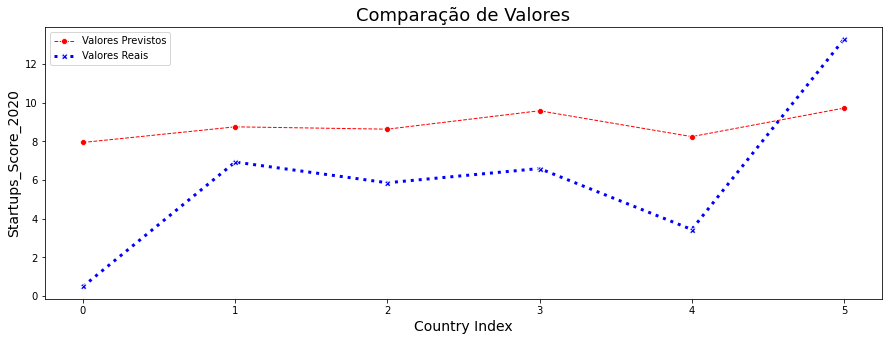

In [27]:
res_model(model_l)

<AxesSubplot:xlabel='Startups_Score_2020', ylabel='Density'>

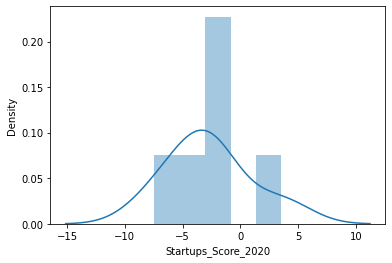

In [28]:
#ytest = ytest.astype(float)
sns.distplot(y_test - ypred_lasso)

### Gridsearch Lasso

In [29]:
m_lasso = Lasso(random_state=SEED, fit_intercept=True)

alphas = np.logspace(-1, 2, 20)
max_iter_range = np.arange(10, 20, 1)

tuned_parameters = [dict(alpha= alphas,
                         max_iter = max_iter_range)]
n_folds = 3

clf = GridSearchCV(m_lasso, param_grid = tuned_parameters, cv=n_folds, refit=False, return_train_score=True)

clf.fit(X, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

#scores, scores_std, 
clf.best_score_, clf.best_params_

(-0.07791256373453315, {'alpha': 1.8329807108324356, 'max_iter': 17})

In [30]:
#heatmap pós limpeza dos outliers
#plt.figure(figsize=(15,10))
#sns.heatmap(DF_std2.corr(), annot = True, cmap ='Blues')

<AxesSubplot:xlabel='Country', ylabel='EFW1_Econ_10_20'>

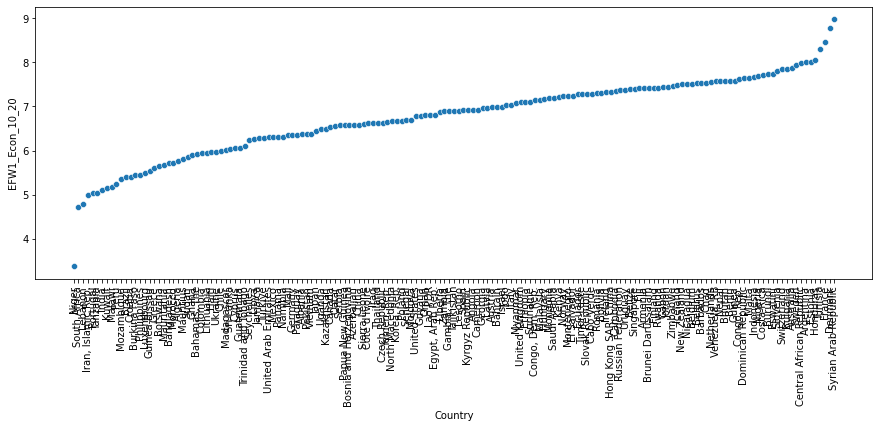

In [31]:
# Gráfico de Ranking

topic = 'EFW1_Econ_10_20'

data = DF_std.sort_values(by = topic).reset_index(drop=True)

ax = sns.scatterplot(data = data , x = data.Country , y = data[topic])
ax.figure.set_size_inches(15, 5)
plt.xticks(rotation=90)

ax

<AxesSubplot:xlabel='Country', ylabel='EFW1_Econ_10_20'>

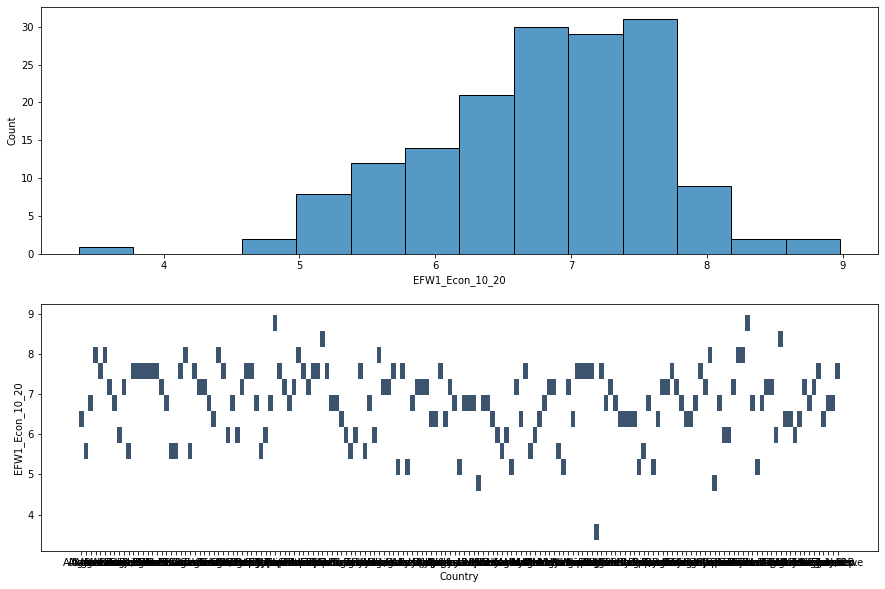

In [32]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(15,10))

sns.histplot(ax=axes[0], data = DF_std.EFW1_Econ_10_20)

sns.histplot(ax=axes[1], data = DF_std,  
             x = 'Country',
             y = 'EFW1_Econ_10_20')

## Elastic Net Regression

In [33]:
# Fit regression model
alpha = 1.08
model_en = ElasticNet(alpha=alpha,
                      l1_ratio=0.5,
                      fit_intercept=True,
                      max_iter=6,
                      tol=0.0001,
                      random_state=SEED)

model_en.fit(X_train, y_train)

ypred_en = model_en.predict(X_test)

resultados(ypred_en)
#print('Cross Validation:', CV.round(2))

#print('Coeficientes: ', model_en.coef_)

MAE: 5.36
MSE: 34.66
RMSE: 5.89
MAPE: 3.14
R2: -1.28


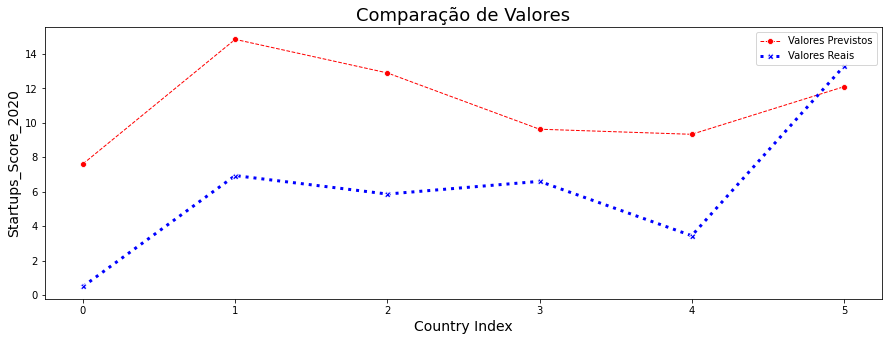

In [34]:
res_model(model_en)

In [35]:
G = DF_std[feature_cols].copy()
G.columns[model_en.coef_  > 0.75]
#model_en.coef_[model_en.coef_ > 0.5]

Index(['No_billionaires', 'Networth_bill', 'No_unicorns',
       'Valuation_startups_US$_billions', 'EFW2_2L_80_00', 'WB_Serv_80_00',
       'WB_Serv_00_10'],
      dtype='object')

### Gridsearch Elastic Net

In [36]:
model_en2 = ElasticNet(l1_ratio=0.5, fit_intercept=True, tol=0.0001, random_state=SEED)

alphas = np.logspace(-1, 1, 30)
max_iter_range = np.arange(1, 10, 1)

tuned_parameters = [dict(alpha= alphas,
                         max_iter = max_iter_range)]
n_folds = 5

clf = GridSearchCV(model_en2, param_grid = tuned_parameters, cv=n_folds, refit=False, return_train_score=True)

clf.fit(X, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

#scores, scores_std, 
clf.best_score_, clf.best_params_

(-0.17344768215948328, {'alpha': 1.0826367338740546, 'max_iter': 7})

In [37]:
#df_efw_fra.columns

## Decision Tree

In [38]:
# Fit regression model
model_dtr = tree.DecisionTreeRegressor(criterion='squared_error',
                                  splitter='best',
                                  ccp_alpha=0.4,
                                  max_depth=3,
                                  min_samples_split=2,
                                  min_samples_leaf=3,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=None,
                                  max_leaf_nodes=None,
                                  )
model_dtr.fit(X_train, y_train)
ypred_dt = model_dtr.predict(X_test)

resultados(ypred_dt)

MAE: 3.59
MSE: 16.8
RMSE: 4.1
MAPE: 1.44
R2: -0.11


In [39]:
G.columns[model_dtr.feature_importances_ > 0]

Index(['Valuation_startups_US$_billions', 'EFW2_Rank_00_10', 'EFW2_4Dii_10_20',
       'EFW2_5R_80_00'],
      dtype='object')

In [40]:
#fig = plt.figure(figsize=(15,5))
#_ = tree.plot_tree(ypred_dt,feature_names=feature_cols,filled=True,rounded=True, proportion=True)
#plt.show()

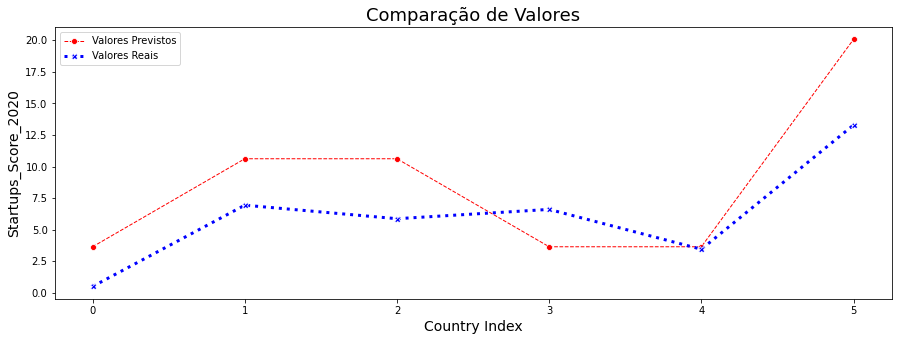

In [41]:
res_model(model_dtr)

### GridsearchCV Decision Tree

In [42]:
alpha_range = np.arange(0, 1, 0.01)
max_depth_range = np.arange(1, 5, 1)
min_samples_split_range = np.arange(2, 5, 1)
min_samples_leaf_range = np.arange(2, 5, 1)


param_grid = dict(ccp_alpha = alpha_range, 
                  max_depth = max_depth_range,
                  min_samples_split = min_samples_split_range,
                  min_samples_leaf = min_samples_leaf_range)

folds = KFold(n_splits=5, random_state=17, shuffle=True)

grid = GridSearchCV(model_dtr, param_grid, cv = folds, scoring = 'neg_mean_squared_error')

grid.fit(X, y)
grid.best_params_

{'ccp_alpha': 0.04,
 'max_depth': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

## XGBoost

- learning_rate >>> step size shrinkage used to prevent overfitting. Range is [0,1]

- max_depth >>> determines how deeply each tree is allowed to grow during any boosting round.

- subsample >>> percentage of samples used per tree. Low value can lead to underfitting.

- colsample_bytree >>> percentage of features used per tree. High value can lead to overfitting.

- n_estimators >>> number of trees you want to build.

- objective >>> determines the loss function to be used like reg:linear for regression problems, reg logistic for classification problems with only decision, binary:logistic for classification problems with probability.

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.

- alpha: L1 regularization on leaf weights. A large value leads to more regularization.

- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [43]:
data = X
label = y

data_dmatrix = xgb.DMatrix(data=data,label=label)

model_xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                                alpha = 0.01,
                                colsample_bytree = 0.3, 
                                learning_rate = 0.14,
                                max_depth = 2, 
                                n_estimators = 10)

model_xg_reg.fit(X_train,y_train)
ypred_xgb = model_xg_reg.predict(X_test)


cv = ShuffleSplit(n_splits=3, test_size=TS, random_state=SEED)

CV = cross_val_score(model_xg_reg, X, y, cv=cv)

resultados(ypred_xgb)
print('Cross Validation:', CV.round(2))
#xgb.plot_importance(model_xg_reg)
#xgb.to_graphviz(model_xg_reg, num_trees=2)

[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 1.0
MSE: 1.67
RMSE: 1.29
MAPE: 0.93
R2: 0.89
Cross Validation: [0.89 0.41 0.24]


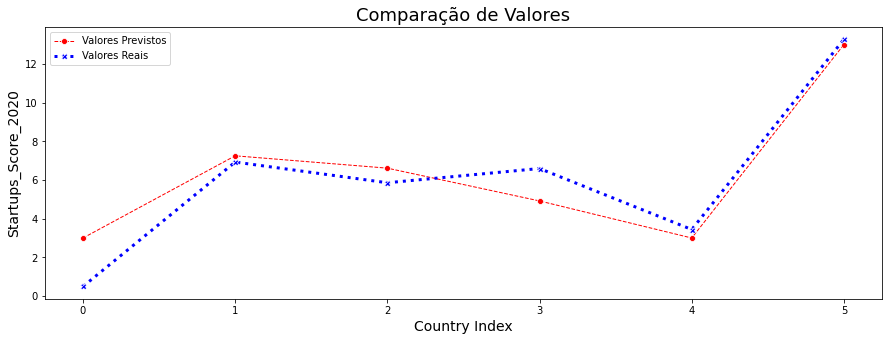

In [44]:
res_model(model_xg_reg)

### Gridsearch XGBoost

In [45]:
params = {"objective": ["reg:linear"],
          'alpha': np.logspace(-2, 2, 20),
          'colsample_bytree': [0.3],
          'learning_rate':  np.arange(0, 0.2, 0.02),
          'max_depth': [2],  #np.arange(2, 10, 1),
          'n_estimators': [10]} #np.arange(6, 12, 2)}


xgb_grid = GridSearchCV(estimator=model_xg_reg,
                        param_grid=params,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[00:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.08047503231308754
{'alpha': 0.01, 'colsample_bytree': 0.3, 'learning_rate': 0.14, 'max_depth': 2, 'n_estimators': 10, 'objective': 'reg:linear'}


In [46]:
XG = DF_std[feature_cols].copy()
query_cols = list(XG.columns[model_xg_reg.feature_importances_ > 0])

cols_index = [XG.columns.get_loc(col) for col in query_cols]
#print(cols_index)
idx_dic = {}
for col in XG[query_cols]:
    idx_dic[col] = XG.columns.get_loc(col)
print(idx_dic)

{'No_billionaires': 0, 'Networth_bill': 1, 'No_unicorns': 2, 'Valuation_startups_US$_billions': 3, 'EFW1_5.b__80_00': 94, 'EFW2_Econ_80_00': 106, 'EFW2_2C_80_00': 145, 'EFW2_4Bii_00_10': 197, 'EFW2_4F_00_10': 215}


In [47]:
query_cols, model_xg_reg.feature_importances_[model_xg_reg.feature_importances_ > 0]

(['No_billionaires',
  'Networth_bill',
  'No_unicorns',
  'Valuation_startups_US$_billions',
  'EFW1_5.b__80_00',
  'EFW2_Econ_80_00',
  'EFW2_2C_80_00',
  'EFW2_4Bii_00_10',
  'EFW2_4F_00_10'],
 array([0.18395698, 0.18252972, 0.01758107, 0.08415739, 0.26990083,
        0.18166308, 0.03809769, 0.02547869, 0.0166345 ], dtype=float32))

In [48]:
#df_efw_fra.columns

In [49]:
keys_list = query_cols
values_list = (list(model_xg_reg.feature_importances_[model_xg_reg.feature_importances_ > 0].round(3)))
zip_iterator = zip(keys_list, values_list)
a_dictionary = dict(zip_iterator)

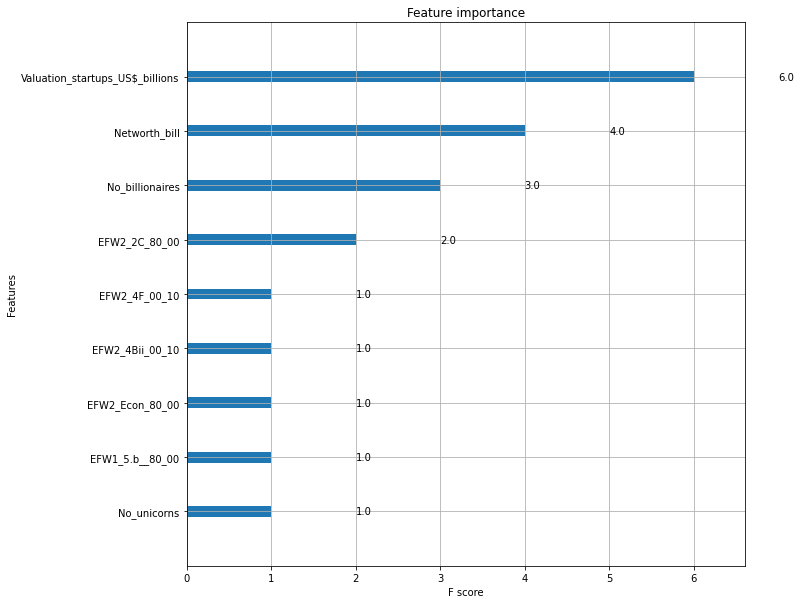

In [70]:
#XG = DF_std[feature_cols].copy()
#labels = list(XG.columns[model_xg_reg.feature_importances_ > 0])

model_xg_reg.get_booster().feature_names = feature_cols
xgb.plot_importance(model_xg_reg)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

# Completando Valores de Colunas

In [51]:
#Completando com os valores do modelo XGBoost

X = DF_std[DF_std['Startups_Score_2020'] == 0 ][feature_cols].copy()
y_new = model_xg_reg.predict(X).round(3)

y_new
#DF_std[DF_std['Startups_Score_2020'] > 0 ][feature_cols_base].head()

array([17.865, 52.421, 17.865, 17.865, 17.865, 17.865, 52.421, 17.865,
       52.421, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 32.68 , 17.865, 17.865, 17.865, 17.865, 52.421,
       17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 32.68 , 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 17.865, 64.44 , 17.865, 17.865, 17.865,
       52.421, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       32.68 , 17.865, 17.865, 17.865, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 52.421, 17.865, 17.865, 17.865, 17.865,
       17.865, 17.865, 17.865, 17.865, 17.865, 52.421], dtype=float32)

# Coletando Features consideradas importantes pelos modelos.

In [63]:
## Features

bfi = [['Country', 'Startups_Ranking_2020', 'EFW2_Econ_80_00', 'EFW2_Econ_00_10']]

#Elastic Net
G = DF_std[feature_cols].copy()
bfi.append(list(G.columns[model_en.coef_  > 0.75]))

#Decision Tree
bfi.append(list(G.columns[model_dtr.feature_importances_ > 0]))

#XGBoost
bfi.append(list(XG.columns[model_xg_reg.feature_importances_ > 0]))

bfi = list(set(sum(bfi, [])))

dct = {'Country': 'País',
       'No_unicorns': 'Número de Unicórnios',
       'No_billionaires': 'Número de Bilionários',
       'Valuation_startups_US$_billions': 'Valuation Startups US$ Bilhões',
       'Networth_bill': 'Riqueza dos Bilionários US$ Bilhões',
       'Startups_Ranking_2020': 'Startups Ranking 2020',
       'EFW1_1.b__00_10': 'Comércio',
       'EFW1_5.b__80_00': 'Regulamentos do Mercado de Trabalho 1980-2000',
       'EFW2_4Bii_00_10': 'Custos de Conformidade de Importação e Exportação',
       'EFW2_4Di_10_20': 'Abertura Financeira',
       'EFW2_4Dii_10_20': 'Controle de Capital',
       'EFW2_Econ_80_00': 'Índice de Liberdade Econômica 1980-2000',
       'EFW2_Econ_00_10': 'Índice de Liberdade Econômica 2000-2010',
       'EFW2_4F_00_10': 'Liberdade para Negociar Internacionalmente',
       'EFW2_2L_80_00': 'Sistema Jurídico Geral',
       'EFW2_Rank_00_10': 'Ranking de Liberdade Econômica',
       'EFW2_1B_00_10': 'Transferências e Subsídios',
       'EFW2_5R_80_00': 'Regulamento Geral',
       'EFW2_2C_80_00': 'Direitos de Propriedade',
       'EFW2_5B_00_10': 'Regulamentos do Mercado de Trabalho 2000-2010', 
       'WB_Serv_80_00': 'Serviços % do PIB 1980-2000',
       'WB_Serv_00_10': 'Serviços % do PIB 2000-2010',
        }

#bfi_pt = list(set(map(dct.get, bfi)))

DF_best_features = DF_std.loc[:,bfi].round(1)
DF_best_features.columns = map(dct.get, list(DF_best_features.columns))

first_column = DF_best_features.pop('País')  
DF_best_features.insert(0, 'País', first_column)

second_column = DF_best_features.pop('Índice de Liberdade Econômica 2000-2010')  
DF_best_features.insert(1, 'Índice de Liberdade Econômica 2000-2010', second_column)

third_column = DF_best_features.pop('Startups Ranking 2020')  
DF_best_features.insert(2, 'Startups Ranking 2020', third_column)


# Adicionando a média mundial:

MM = pd.DataFrame(DF_best_features.mean().round(1)).transpose()
MM.insert(0, 'País', 'Média Mundial')
DF_best_features = DF_best_features.append(MM, ignore_index=True)
 
# TOP 10 Países
cond1=DF_best_features['Startups Ranking 2020'] <=10  
cond2=DF_best_features['Startups Ranking 2020'] > 0
DF_best_features[(cond1) & (cond2)].sort_values(by='Startups Ranking 2020')

,País,Índice de Liberdade Econômica 2000-2010,Startups Ranking 2020,Serviços % do PIB 2000-2010,Controle de Capital,Regulamento Geral,Ranking de Liberdade Econômica,Direitos de Propriedade,Riqueza dos Bilionários US$ Bilhões,Regulamentos do Mercado de Trabalho 1980-2000,Serviços % do PIB 1980-2000,Número de Bilionários,Valuation Startups US$ Bilhões,Custos de Conformidade de Importação e Exportação,Liberdade para Negociar Internacionalmente,Sistema Jurídico Geral,Índice de Liberdade Econômica 1980-2000,Número de Unicórnios
154,United States,8.5,1.0,74.5,1.8,8.6,4.3,8.0,4685.1,9.4,71.9,719.0,1111.2,9.3,8.4,8.6,8.6,215.0
153,United Kingdom,8.4,2.0,69.0,8.0,8.1,5.6,7.4,199.1,4.8,65.6,49.0,183.6,9.1,9.1,8.2,8.1,30.0
72,Israel,7.3,3.0,66.2,8.2,4.6,46.4,7.1,111.6,4.2,58.7,29.0,61.4,8.7,8.7,6.1,5.3,33.0
28,Canada,8.2,4.0,63.2,3.6,8.4,7.2,6.8,307.9,8.2,58.1,64.0,48.8,8.9,8.5,8.5,8.2,19.0
55,Germany,7.8,5.0,62.7,7.3,5.8,19.7,7.7,604.0,6.8,58.8,130.0,47.4,9.3,8.7,8.4,7.8,18.0
139,Sweden,7.8,6.0,62.0,7.4,6.4,22.1,6.8,165.7,7.1,57.8,45.0,65.4,9.4,8.7,8.5,7.3,8.0
32,China,5.8,7.0,42.2,0.6,3.6,109.9,4.1,1938.4,7.9,31.4,515.0,764.3,7.3,6.3,4.7,4.5,86.0
140,Switzerland,8.6,8.0,69.5,7.5,6.9,2.4,8.5,181.9,5.1,66.1,41.0,5.0,9.0,8.3,8.7,8.4,4.0
5,Australia,8.2,9.0,64.3,0.1,7.5,7.8,7.5,205.1,7.6,59.5,44.0,51.2,9.0,7.7,8.5,7.9,6.0
131,Singapore,8.7,10.0,65.0,9.1,7.5,2.6,7.2,105.7,7.3,62.0,25.0,8.2,9.6,9.4,7.9,8.1,8.0


In [71]:
#df_ext[2].columns

In [72]:
#df_efw_fra.columns

In [73]:
DF_best_features.to_csv(r'DF_best_features.csv', index = False)

In [77]:
#DF_std_ext2.columns

# Rascunhos

In [ ]:
#importancia das features
#importancia = model_dtr.feature_importances_
#resumo da importância
#for i,v in enumerate(importancia):
#    print('Feature: %0d, Score: %.5f' % (i,v))
#plotagem dos dados
#ax = plt.figure(figsize=(15,8))
#ax = plt.bar([x for x in range(len(importancia))], importancia)
#plt.show();

In [151]:
#list(DF_std.columns)[268:]

Country = 'Brazil'

df_pie = DF_std.loc[:, ['Country', 'WB_Agri_10_20', 'WB_Indu_00_10', 'WB_Serv_10_20']]
df_pie.columns = ['Country', '% Agro', '% Ind', '% Serv']
pie = df_pie[df_pie.Country == Country].transpose().iloc[1:,:]
pie = pie.reset_index()
pie.columns = ['Index', 'Country']
Outros = {'Outros': (1 - (pie.Country.sum()/100))}
DF_Outros = pd.DataFrame.from_dict(Outros, orient='index')
DF_Outros = DF_Outros.reset_index()
DF_Outros.columns = ['Index', 'Country']
pie = pie.append(DF_Outros, ignore_index=True)

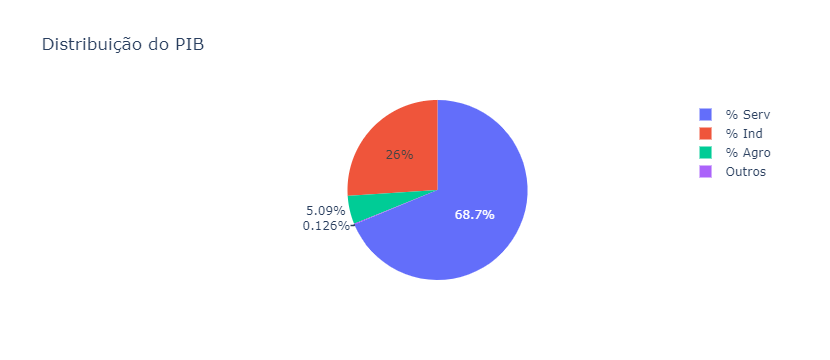

In [154]:
fig = px.pie(pie, values='Country', names='Index', title='Distribuição do PIB')
fig.show()